In [1]:
# -*- coding: utf-8 -*-
import h5py
import numpy as np
import os
import pickle

from sklearn.model_selection import train_test_split
from lesion_extraction_2d.lesion_extractor_2d import parse_centroid, get_lesion_info, get_train_data, extract_lesion_2d

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

from PIL import Image
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def oversample(X, y, random_state=42, verbose=False):
    np.random.seed(random_state)
    len_oversampled = len(y) - int(y.sum()) * 2
    oversampled = np.random.choice(np.where(y == 1)[0], len_oversampled)
    X_bal = np.concatenate((X, X[oversampled]), 0)
    y_bal = np.concatenate((y, y[oversampled]), 0)
    if verbose:
        print("N, N_pos, num_oversampled: ", len(y), int(y.sum()), len_oversampled)
    return X_bal, y_bal

def extract_2d(img, centroid, size=None, resolution=None):
    if resolution: 
        img = scipy.ndimage.zoom(img, resolution)
        centroid.zoom(resolution)
    if len(img.shape) == 3:
        if centroid.z < 0 or centroid.z >= len(img):
            return None
        img_slice = img[centroid.z]
    else:
        img_slice = img
    if size:
        x_start = int(centroid.x - size / 2)
        x_end = int(centroid.x + size / 2)
        y_start = int(centroid.y - size / 2)
        y_end = int(centroid.y + size / 2)
        img_slice = img_slice[y_start:y_end, x_start:x_end]
    return img_slice

def get_2d_images(h5_file, query_words, size=None, resolution=None):
    lesion_info = get_lesion_info(h5_file, query_words)
    X, y, lesion_attributes, previous_patient = [], [], [], ''
    for infos, image in lesion_info:
        current_patient = infos[0]['name'].split('/')[1]
        if current_patient == previous_patient:
            print('Warning in {}: Found duplicate match {} for {}. Skipping...'
                  .format(get_2d_images.__name__, infos[0]['name'].split('/')[-1], current_patient))
            continue
        for lesion in infos:
            centroid = parse_centroid(lesion['ijk'])
            lesion_img = image[min(max(centroid.z, 0), len(image) - 1)]
            if centroid.z < 0 or centroid.z >= len(image):
                print('Warning in {}: ijk out of bounds for {}. No lesion extracted'
                      .format(get_2d_images.__name__, lesion))
                continue
            X.append(lesion_img)
            y.append(lesion['ClinSig'] == b"TRUE")
            lesion_attributes.append(lesion)
        previous_patient = current_patient
    return np.asarray(X), np.asarray(y), np.asarray(lesion_attributes)

def gather_findings_2d(query, data, resolution, size=64):
    findings = {attr['patient_id'] + '-' + attr['fid']:{} for q in query for attr in data[q][2]}
    for q in query:
        images, labels, attrs = data[q]
        for i in range(len(images)):
            f = attrs[i]['patient_id'] + '-' + attrs[i]['fid']
            image = images[i]
            image = image.astype(np.float64)
            centroid = parse_centroid(attrs[i]['ijk'])        
            image = extract_2d(image, centroid, size, resolution[q])
            image = (image - image.min()) / (image.max() - image.min())
            if not np.isfinite(image).all(): print("Invalid: ", f, q)
            if image is None: print(f)
            findings[f][q] = image
            if 'label' not in findings[f]:
                findings[f]['label'] = labels[i]
            else:
                assert(findings[f]['label'] == labels[i])
    intersec = {}
    for k, v in findings.items():
        if len(v.keys()) == len(query) + 1:
            intersec[k] = v
        else:
            print("Missing: {} {}".format(k, [q for q in query if q not in v]))
    print("Total findings for train/val: ", len(intersec))
    return intersec

## DWI
def filename_to_patient_id(name):
    return name[11:15]

def get_lesion_info_from_query(query):
    include_attrs = ['ijk', 'VoxelSpacing', 'Zone', 'ClinSig']
    lesions_info = []
    for h5_group in query:
        if 'pixel_array' not in h5_group or 'lesions' not in h5_group:
            print('Warning in {}: No pixel array or lesions found for {}. Skipping...'
                  .format(get_lesion_info, h5_group))
            continue
        pixel_array = h5_group['pixel_array'][:]  # The actual DICOM pixel data
        patient_age = h5_group['pixel_array'].attrs.get('Age')
        lesion_info = []
        for finding_id in h5_group['lesions'].keys():
            lesion_dict = {
                'name': h5_group.name,
                'patient_id': filename_to_patient_id(h5_group.name)
            }
            for attr in include_attrs:
                # Per lesion finding, gather the attributes necessary for actual lesion extraction from DICOM image
                lesion_dict[attr] = h5_group['lesions'][finding_id].attrs.get(attr)
            lesion_dict['fid'] = finding_id
            lesion_dict['Age'] = patient_age
            lesion_info.append(lesion_dict)
        lesions_info.append([lesion_info, pixel_array])
    return lesions_info

def get_train_data_from_lesion_info(lesion_info):
    X = []
    y = []
    lesion_attributes = []
    previous_patient = ''
    for infos, image in lesion_info:
        current_patient = infos[0]['name'].split('/')[1]
        if current_patient == previous_patient:
            print('Warning in {}: Found duplicate match {} for {}. Skipping...'
                  .format(get_train_data.__name__, infos[0]['name'].split('/')[-1], current_patient))
            continue
        for lesion in infos:

            # for dwi
            centroid = parse_centroid(lesion['ijk'])
            if len(image) >= 80: # for 218 and 227
                image = image[:len(image)*3//4]
            slices = [image[start:start+len(image)//3] for start in range(0, len(image), len(image)//3)]
            lesion_slices = [img[centroid.z] for img in slices if centroid.z >= 0 and centroid.z < len(img)]
            if lesion_slices == []:
                print('Warning in {}: ijk out of bounds for {}. No lesion extracted'
                    .format(get_train_data_from_lesion_info.__name__, lesion))
                continue
            lesion_img = np.vstack([slice[np.newaxis,:] for slice in lesion_slices])

            X.append(lesion_img)
            y.append(lesion['ClinSig'] == b"TRUE")
            lesion_attributes.append(lesion)

        previous_patient = current_patient

    # return np.asarray(X), np.asarray(y), np.asarray(lesion_attributes)
    return X, y, lesion_attributes


## TBAKD3 Train

In [50]:
# # Combine tbak with d3
# query = tbak_query + dwi_query
# findings = {}
# for k in set(tbak_findings).intersection(set(dwi_findings)):
#     findings[k] = tbak_findings[k]
#     findings[k].update(dwi_findings[k])
# len(findings), [k for k in tbak_findings if k not in findings], [k for k in dwi_findings if k not in findings]

(319,
 [],
 ['0025-1', '0025-2', '0025-3', '0025-4', '0105-3', '0148-1', '0148-2'])

In [55]:
# images = np.stack([np.stack([findings[f][q] for q in query]) for f in findings])
# labels = np.stack([findings[f]['label'] for f in findings])
# pickle.dump((images, labels), open('tbakd3_npy/train.pkl', "wb"))
images, labels = pickle.load(open('tbakd3_npy/train.pkl', "rb"))

In [54]:
images.shape, images.min(), images.max(), np.isfinite(images).all()

((319, 7, 64, 64), 0.0, 1.0, True)

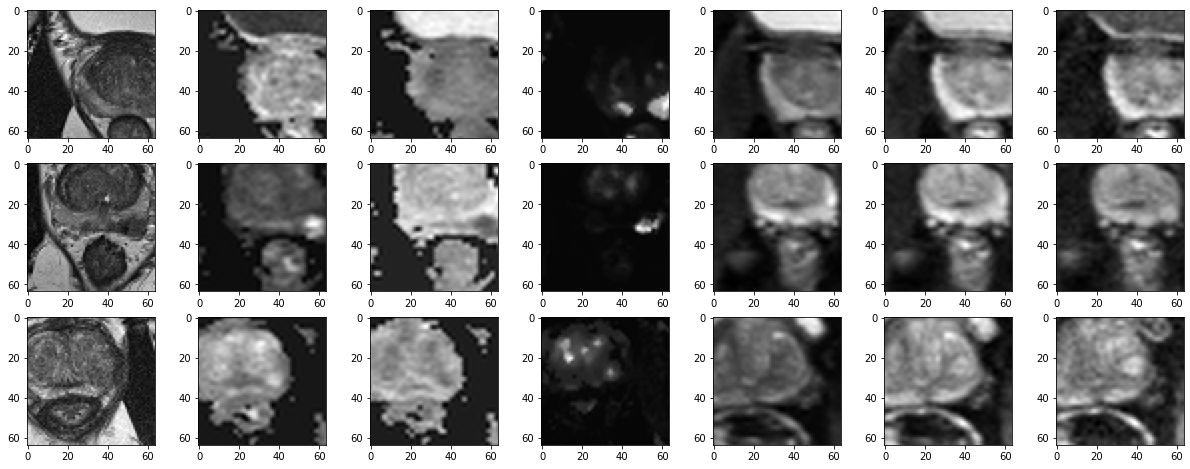

In [56]:
column = len(query) + 1 if len(query) < 5 else len(query)
row = [0, 1, 2]
fig, ax = plt.subplots(len(row), column, figsize=(3 * column, 8))
for r in row:
    if len(query) < 5: 
        for c in range(len(query)):
            ax[r, c].imshow(images[r, c], cmap='gray')
        ax[r, -1].imshow(np.moveaxis(images[r], 0, -1))
    else:
        for c in range(column):
            ax[r, c].imshow(images[r, c], cmap='gray')
fig.show()

In [58]:
from sklearn.model_selection import StratifiedKFold
X, y = images, labels
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds = [(X[train_index], X[test_index], y[train_index], y[test_index]) for train_index, test_index in skf.split(X, y)]

In [65]:
X_train, X_valid, y_train, y_valid = folds[0]

In [66]:
a, b = oversample(X_train, y_train)

In [73]:
dirname = 'tbakd3_npy/5folds'
for fold_i, fold in enumerate(folds):
    X_train, X_valid, y_train, y_valid = fold
    for split in ['/train', '/train_bal', '/valid', '/valid_bal']:
        for label in ['/0', '/1']:
            path = dirname + f'/{fold_i}' + split + label
            os.makedirs(path, exist_ok=True)
        X = X_train if 'train' in split else X_valid
        y = y_train if 'train' in split else y_valid
        if 'bal' in split:
            X, y = oversample(X, y, verbose=True)
        print(dirname + f'/{fold_i}' + split, len(X))
        for i in range(len(X)):
            image = X[i]
            rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
            im = np.moveaxis(rescaled, 0, -1)
            path = dirname + f'/{fold_i}' + split + '/{}/{}.npy'.format(1 if y[i] else 0, i)
            np.save(open(path, "wb"), im)

tbakd3_npy/5folds/0/train 255
N, N_pos, num_oversampled:  255 59 137
tbakd3_npy/5folds/0/train_bal 392
tbakd3_npy/5folds/0/valid 64
N, N_pos, num_oversampled:  64 15 34
tbakd3_npy/5folds/0/valid_bal 98
tbakd3_npy/5folds/1/train 255
N, N_pos, num_oversampled:  255 59 137
tbakd3_npy/5folds/1/train_bal 392
tbakd3_npy/5folds/1/valid 64
N, N_pos, num_oversampled:  64 15 34
tbakd3_npy/5folds/1/valid_bal 98
tbakd3_npy/5folds/2/train 255
N, N_pos, num_oversampled:  255 59 137
tbakd3_npy/5folds/2/train_bal 392
tbakd3_npy/5folds/2/valid 64
N, N_pos, num_oversampled:  64 15 34
tbakd3_npy/5folds/2/valid_bal 98
tbakd3_npy/5folds/3/train 255
N, N_pos, num_oversampled:  255 59 137
tbakd3_npy/5folds/3/train_bal 392
tbakd3_npy/5folds/3/valid 64
N, N_pos, num_oversampled:  64 15 34
tbakd3_npy/5folds/3/valid_bal 98
tbakd3_npy/5folds/4/train 256
N, N_pos, num_oversampled:  256 60 136
tbakd3_npy/5folds/4/train_bal 392
tbakd3_npy/5folds/4/valid 63
N, N_pos, num_oversampled:  63 14 35
tbakd3_npy/5folds/4/val

In [247]:
splitted = train_test_split(images, labels, test_size=0.25, random_state=0, stratify=labels)
X_train, X_valid, y_train, y_valid = splitted
len_oversampled = len(y_train) - int(y_train.sum()) * 2
print("Train, len_1, len_oversampled: ", 
    len(y_train), int(y_train.sum()), len_oversampled)
print("Valid, len_1: ", len(y_valid), int(y_valid.sum()))

oversampled = np.random.choice(np.where(y_train == 1)[0], len_oversampled)
X_train = np.concatenate((X_train, X_train[oversampled]), 0)
y_train = np.concatenate((y_train, y_train[oversampled]), 0)

Train, len_1, len_oversampled:  231 50 131
Valid, len_1:  78 17


In [249]:
dirname = 'tbakd3_npy'
_ = [os.makedirs(dirname+split+label) for split in ['/train', '/valid', '/valid_bal'] for label in ['/0', '/1']]
for i in range(X_train.shape[0]):
    image = X_train[i]
    rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    im = np.moveaxis(rescaled, 0, -1)
    path = dirname + '/train/{}/{}.npy'.format(1 if y_train[i] else 0, i)
    np.save(open(path, "wb"), im)
for i in range(X_valid.shape[0]):
    image = X_valid[i]
    rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    im = np.moveaxis(rescaled, 0, -1)
    path = dirname + '/valid/{}/{}.npy'.format(1 if y_valid[i] else 0, i)
    np.save(open(path, "wb"), im)
    if (y_valid[:i] == y_valid[i]).sum() < y_valid.sum():
        path = dirname + '/valid_bal/{}/{}.npy'.format(1 if y_valid[i] else 0, i)
        np.save(open(path, "wb"), im)

## TBAKD3 Test

In [3]:
h5_file_location = os.path.join('./','prostatex-test-ALL.hdf5')
h5_file = h5py.File(h5_file_location, 'r')
h5_file[next(iter(h5_file))].keys()

<KeysViewHDF5 ['Ktrans', 'ep2d_diff_tra_DYNDIST', 'ep2d_diff_tra_DYNDISTCALC_BVAL', 'ep2d_diff_tra_DYNDIST_ADC', 't2_tse_cor', 't2_tse_sag', 't2_tse_tra', 'tfl_3d PD ref_tra_1.5x1.5_t3']>

In [4]:
tbak_query = ['t2_tse_tra', 'CALC_BVAL', 'diff_ADC', 'Ktrans']
tbak_resolution = {'t2_tse_tra':0.5, 'CALC_BVAL': 2, 'diff_ADC': 2, 'Ktrans': 1.5}
tbak_data = {q: get_2d_images(h5_file, [q]) for q in tbak_query}
tbak_findings = gather_findings_2d(tbak_query, tbak_data, tbak_resolution, size=64)

Warning in <function get_lesion_info at 0x7f2e15818a60>: No pixel array or lesions found for <HDF5 group "/ProstateX-0325/t2_tse_tra" (1 members)>. Skipping...
Warning in <function get_lesion_info at 0x7f2e15818a60>: No pixel array or lesions found for <HDF5 group "/ProstateX-0331/t2_tse_tra" (1 members)>. Skipping...
Warning in get_2d_images: Found duplicate match t2_tse_tra_S5_ND for ProstateX-0307. Skipping...


/home/hanliu/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Warning in <function get_lesion_info at 0x7f2e15818a60>: No pixel array or lesions found for <HDF5 group "/ProstateX-0325/ep2d_diff_tra_DYNDISTCALC_BVAL" (1 members)>. Skipping...
Warning in <function get_lesion_info at 0x7f2e15818a60>: No pixel array or lesions found for <HDF5 group "/ProstateX-0331/ep2d_diff_tra_DYNDIST_MIXCALC_BVAL" (1 members)>. Skipping...
Warning in <function get_lesion_info at 0x7f2e15818a60>: No pixel array or lesions found for <HDF5 group "/ProstateX-0325/ep2d_diff_tra_DYNDIST_ADC" (1 members)>. Skipping...
Warning in <function get_lesion_info at 0x7f2e15818a60>: No pixel array or lesions found for <HDF5 group "/ProstateX-0331/ep2d_diff_tra_DYNDIST_MIX_ADC" (1 members)>. Skipping...
Warning in get_2d_images: Found duplicate match ep2d-advdiff-MDDW-12dir_spair_511b_ADC for ProstateX-0218. Skipping...
Warning in get_2d_images: ijk out of bounds for {'name': '/ProstateX-0335/Ktrans', 'patient_id': '0335', 'ijk': b'49 59 -2', 'VoxelSpacing': b'1.5,1.5,3.', 'Zone':

<ipython-input-2-6793e2894857>:60: RuntimeWarning: invalid value encountered in true_divide
  image = (image - image.min()) / (image.max() - image.min())


Invalid:  0271-1 Ktrans
Missing: 0227-1 ['CALC_BVAL']
Missing: 0227-2 ['CALC_BVAL']
Total findings for train/val:  206


In [5]:
tbak_findings['0271-1']['Ktrans'] = np.zeros_like(tbak_findings['0271-1']['Ktrans'])

In [6]:
word = 'diff'
query_result = [
        h5_file[patient_id][dcm_series]  # We want patients with DICOM series such that:
        for patient_id in h5_file.keys()  # For all patients
        for dcm_series in h5_file[patient_id].keys()  # For all DICOM series
        if word in dcm_series.lower() and all([ exclude not in dcm_series.lower() for exclude in ['adc', 'calc', 'mddw']])
        ]
dwi_lesion_info = get_lesion_info_from_query(query_result)
dwi_data_all = get_train_data_from_lesion_info(dwi_lesion_info)
dwi_query = ["DWI0", "DWI1", "DWI2"]
dwi_resolution = {'DWI0': 2, 'DWI1': 2, 'DWI2': 2}
dwi_data = {q:([x[i] for x in dwi_data_all[0]], dwi_data_all[1], dwi_data_all[2]) for i, q in enumerate(dwi_query)}
dwi_findings = gather_findings_2d(dwi_query, dwi_data, dwi_resolution, 64)

Warning in <function get_lesion_info at 0x7f2e15818a60>: No pixel array or lesions found for <HDF5 group "/ProstateX-0325/ep2d_diff_tra_DYNDIST" (1 members)>. Skipping...
Warning in <function get_lesion_info at 0x7f2e15818a60>: No pixel array or lesions found for <HDF5 group "/ProstateX-0331/ep2d_diff_tra_DYNDIST_MIX" (1 members)>. Skipping...
Warning in get_train_data: Found duplicate match ep2d-advdiff-3Scan-high bvalue 100 for ProstateX-0218. Skipping...
Warning in get_train_data: Found duplicate match ep2d-advdiff-3Scan-high bvalue 1400 for ProstateX-0218. Skipping...
Warning in get_train_data: Found duplicate match ep2d-advdiff-3Scan-high bvalue 500 for ProstateX-0218. Skipping...
Total findings for train/val:  208


In [7]:
[(i[0][0]['name'], i[1].shape[0]) for i in dwi_lesion_info if i[1].shape[0] > 70]

[('/ProstateX-0218/ep2d-advdiff-3Scan-4bval_spair_511b', 80),
 ('/ProstateX-0227/ep2d_DIFF_tra_b50_500_800_1400_alle_spoelen', 84),
 ('/ProstateX-0269/diff tra b 50 500 800 WIP511b alle spoelen', 75)]

In [8]:
findings = dwi_findings.copy()
for k in findings:
    if k in tbak_findings:
        findings[k].update(tbak_findings[k])
findings['0227-1'].keys()

dict_keys(['DWI0', 'label', 'DWI1', 'DWI2'])

In [9]:
tbak_data['t2_tse_tra'][2][36:38]

array([{'name': '/ProstateX-0227/t2_tse_tra', 'patient_id': '0227', 'ijk': b'173 149 8', 'VoxelSpacing': b'0.5625,0.5', 'Zone': b'AS', 'ClinSig': b'NA', 'fid': '1', 'Age': '071Y'},
       {'name': '/ProstateX-0227/t2_tse_tra', 'patient_id': '0227', 'ijk': b'193 194 14', 'VoxelSpacing': b'0.5625,0.5', 'Zone': b'PZ', 'ClinSig': b'NA', 'fid': '2', 'Age': '071Y'}],
      dtype=object)

In [10]:
findings227 = {'0227-1':{}, '0227-2':{}}
tak_query = np.asarray(tbak_query)[[0,2,3]]
for i, k in enumerate(findings227):
    for q in tak_query:
        img = tbak_data[q][0][36:38][i]
        img = img.astype(np.float64)
        attr = tbak_data[q][2][36:38][i]
        crop = extract_2d(img, parse_centroid(attr['ijk']), 64, tbak_resolution[q])
        crop = (crop - crop.min()) / (crop.max() - crop.min())
        findings227[k][q] = crop

In [11]:
for i, k in enumerate(findings227):
    img = dwi_lesion_info[26][1][i]
    img = img.astype(np.float64)
    attr = dwi_lesion_info[26][0][i]
    crop = extract_2d(img, parse_centroid(attr['ijk']), 64, tbak_resolution[q])
    crop = (crop - crop.min()) / (crop.max() - crop.min())
    findings227[k][np.asarray(tbak_query)[1]] = crop

In [12]:
for k in findings227:
    findings[k].update(findings227[k])
list(findings.keys()) == sorted(findings)

True

In [14]:
query = tbak_query + dwi_query
images = np.stack([np.stack([findings[f][q] for q in query]) for f in findings])
labels = np.stack([findings[f]['label'] for f in findings])

In [16]:
images.shape, images.min(), images.max()

((208, 7, 64, 64), 0.0, 1.0)

In [17]:
dirname = 'tbakd3_npy/test/nolabel/'
os.makedirs(dirname)
for i in range(images.shape[0]):
    image = images[i]
    rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    im = np.moveaxis(rescaled, 0, -1)
    np.save(open(dirname + f'{i}.npy', "wb"), im)

## TBAK 2D 64x64

In [3]:
h5_file_location = os.path.join('./','prostatex-train-ALL.hdf5')
h5_file = h5py.File(h5_file_location, 'r')
h5_file[next(iter(h5_file))].keys()

<KeysViewHDF5 ['Ktrans', 'ep2d_diff_tra_DYNDIST', 'ep2d_diff_tra_DYNDISTCALC_BVAL', 'ep2d_diff_tra_DYNDIST_ADC', 't2_tse_cor', 't2_tse_sag', 't2_tse_tra', 'tfl_3d PD ref_tra_1.5x1.5_t3']>

In [24]:
tbak_query = ['t2_tse_tra', 'CALC_BVAL', 'diff_ADC', 'Ktrans']
tbak_resolution = {'t2_tse_tra':0.5, 'CALC_BVAL': 2, 'diff_ADC': 2, 'Ktrans': 1.5}
tbak_data = {q: get_2d_images(h5_file, [q]) for q in tbak_query}
tbak_findings = gather_findings_2d(tbak_query, tbak_data, tbak_resolution, size=64)

Warning in get_2d_images: Found duplicate match t2_tse_tra_exacte_copy_diffusie for ProstateX-0032. Skipping...
Warning in get_2d_images: ijk out of bounds for {'name': '/ProstateX-0148/t2_tse_tra', 'patient_id': '0148', 'ijk': b'201 162 23', 'VoxelSpacing': b'0.5,0.5,4.', 'Zone': b'AS', 'ClinSig': b'TRUE', 'fid': '1', 'Age': '063Y'}. No lesion extracted
Warning in get_2d_images: ijk out of bounds for {'name': '/ProstateX-0148/t2_tse_tra', 'patient_id': '0148', 'ijk': b'149 206 24', 'VoxelSpacing': b'0.5,0.5,4.', 'Zone': b'PZ', 'ClinSig': b'FALSE', 'fid': '2', 'Age': '063Y'}. No lesion extracted


/home/hanliu/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Warning in get_2d_images: ijk out of bounds for {'name': '/ProstateX-0154/ep2d_diff_tra_DYNDISTCALC_BVAL', 'patient_id': '0154', 'ijk': b'37 70 19', 'VoxelSpacing': b'2,2,3', 'Zone': b'SV', 'ClinSig': b'FALSE', 'fid': '3', 'Age': '060Y'}. No lesion extracted
Warning in get_2d_images: Found duplicate match ep2d_diff_tra2x2_Noise0_NoFS_DYNDISTCALC_BVAL for ProstateX-0191. Skipping...
Warning in get_2d_images: ijk out of bounds for {'name': '/ProstateX-0154/ep2d_diff_tra_DYNDIST_ADC', 'patient_id': '0154', 'ijk': b'37 70 19', 'VoxelSpacing': b'2,2,3', 'Zone': b'SV', 'ClinSig': b'FALSE', 'fid': '3', 'Age': '060Y'}. No lesion extracted
Warning in get_2d_images: Found duplicate match ep2d_diff_tra2x2_Noise0_NoFS_DYNDIST_ADC for ProstateX-0191. Skipping...
Warning in get_2d_images: ijk out of bounds for {'name': '/ProstateX-0025/Ktrans', 'patient_id': '0025', 'ijk': b'67 88 -7', 'VoxelSpacing': b'1.5,1.5,3.', 'Zone': b'PZ', 'ClinSig': b'FALSE', 'fid': '1', 'Age': '066Y'}. No lesion extracted


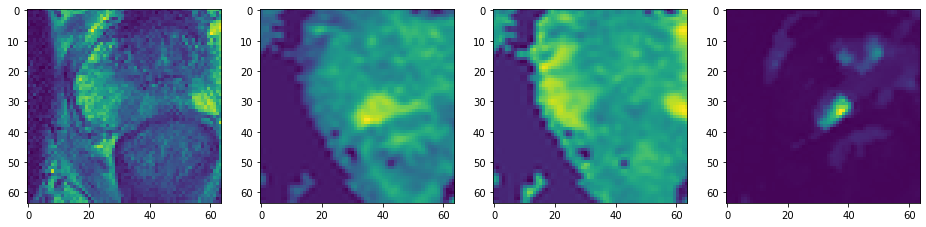

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(16, 9))
for i, img in enumerate([tbak_findings['0000-1'][q] for q in tbak_query]):
    axes[i].imshow(img)

In [27]:
query = tbak_query
findings = tbak_findings
images = np.stack([np.stack([findings[f][q] for q in query]) for f in findings])
labels = np.stack([findings[f]['label'] for f in findings])

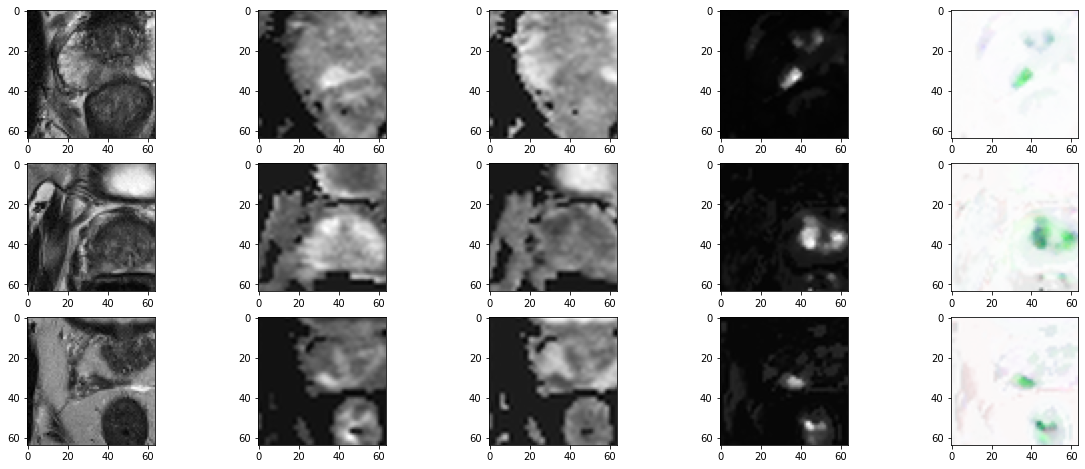

In [28]:
column = len(query) + 1 if len(query) < 5 else len(query)
row = [0, 1, 2]
fig, ax = plt.subplots(len(row), column, figsize=(4 * column, 8))
for r in row:
    if len(query) < 5: 
        for c in range(len(query)):
            ax[r, c].imshow(images[r, c], cmap='gray')
        ax[r, -1].imshow(np.moveaxis(images[r], 0, -1))
    else:
        for c in range(column):
            ax[r, c].imshow(images[r, c], cmap='gray')
fig.show()

In [17]:
splitted = train_test_split(
    images, labels, test_size=0.25, random_state=0, stratify=labels)
# X_train, X_valid, y_train, y_valid = (torch.Tensor(array) for array in splitted)
X_train, X_valid, y_train, y_valid = splitted
len_oversampled = len(y_train) - int(y_train.sum()) * 2
print("Train, len_1, len_oversampled: ", 
    len(y_train), int(y_train.sum()), len_oversampled)
print("Valid, len_1: ", len(y_valid), int(y_valid.sum()))

oversampled = np.random.choice(np.where(y_train == 1)[0], len_oversampled)
X_train = np.concatenate((X_train, X_train[oversampled]), 0)
y_train = np.concatenate((y_train, y_train[oversampled]), 0)

Train, len_1, len_oversampled:  238 55 128
Valid, len_1:  80 19


In [18]:
images.shape

(318, 4, 64, 64)

In [16]:
dirname = 'tbak_npy'
_ = [os.makedirs(dirname+split+label) for split in ['/train', '/valid', '/valid_bal'] for label in ['/0', '/1']]
for i in range(X_train.shape[0]):
    image = X_train[i]
    rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    im = np.moveaxis(rescaled, 0, -1)
    path = dirname + '/train/{}/{}.npy'.format(1 if y_train[i] else 0, i)
    np.save(open(path, "wb"), im)
for i in range(X_valid.shape[0]):
    image = X_valid[i]
    rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    im = np.moveaxis(rescaled, 0, -1)
    path = dirname + '/valid/{}/{}.npy'.format(1 if y_valid[i] else 0, i)
    np.save(open(path, "wb"), im)
    if (y_valid[:i] == y_valid[i]).sum() < y_valid.sum():
        path = dirname + '/valid_bal/{}/{}.npy'.format(1 if y_valid[i] else 0, i)
        np.save(open(path, "wb"), im)

## DWI

In [103]:
h5_file_location = os.path.join('./','prostatex-train-ALL.hdf5')
h5_file = h5py.File(h5_file_location, 'r')
h5_file[next(iter(h5_file))].keys()

<KeysViewHDF5 ['Ktrans', 'ep2d_diff_tra_DYNDIST', 'ep2d_diff_tra_DYNDISTCALC_BVAL', 'ep2d_diff_tra_DYNDIST_ADC', 't2_tse_cor', 't2_tse_sag', 't2_tse_tra', 'tfl_3d PD ref_tra_1.5x1.5_t3']>

In [42]:
word = 'diff'
query_result = [
        h5_file[patient_id][dcm_series]  # We want patients with DICOM series such that:
        for patient_id in h5_file.keys()  # For all patients
        for dcm_series in h5_file[patient_id].keys()  # For all DICOM series
        if word in dcm_series.lower() and all(exclude not in dcm_series.lower() for exclude in ['adc', 'calc'])
        ]

In [43]:
dwi_lesion_info = get_lesion_info_from_query(query_result)
dwi_data_all = get_train_data_from_lesion_info(dwi_lesion_info)

Warning in get_train_data: Found duplicate match t2_tse_tra_exacte_copy_diffusie for ProstateX-0032. Skipping...
Warning in get_train_data_from_lesion_info: ijk out of bounds for {'name': '/ProstateX-0154/ep2d_diff_tra_DYNDIST', 'patient_id': '0154', 'ijk': b'37 70 19', 'VoxelSpacing': b'2,2,3', 'Zone': b'SV', 'ClinSig': b'FALSE', 'fid': '3', 'Age': '060Y'}. No lesion extracted
Warning in get_train_data: Found duplicate match ep2d_diff_tra2x2_Noise0_NoFS_DYNDIST for ProstateX-0191. Skipping...


In [44]:
[(i[0][0]['name'], i[1].shape[0]) for i in dwi_lesion_info if i[1].shape[0] > 70]

[('/ProstateX-0042/ep2d_diff_tra_DYNDIST', 75),
 ('/ProstateX-0181/ep2d_diff_tra_DYNDIST', 75)]

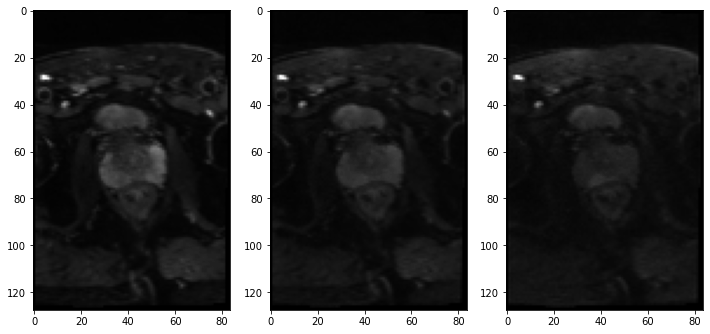

In [45]:
fig, ax = plt.subplots(1,3, figsize=(12, 9))
for i, im in enumerate(dwi_data_all[0][0]):
    ax[i].imshow(im, cmap='gray')

In [46]:
dwi_query = ["DWI0", "DWI1", "DWI2"]
dwi_resolution = {'DWI0': 2, 'DWI1': 2, 'DWI2': 2}
dwi_data = {q:([x[i] for x in dwi_data_all[0]], dwi_data_all[1], dwi_data_all[2]) for i, q in enumerate(dwi_query)}
dwi_findings = gather_findings_2d(dwi_query, dwi_data, dwi_resolution, 64)

Total findings for train/val:  326


## DAK 2D 32x32

In [38]:
# query = ['BVAL', 'ADC', 't2_tse_tra', 't2_tse_cor', 't2_tse_sag', 'Ktrans']
query = ['BVAL', 'ADC', 'Ktrans']
data = {q: get_train_data(h5_file, [q], size_px=32) for q in query}

Warning in get_train_data: ijk out of bounds for {'name': '/ProstateX-0154/ep2d_diff_tra_DYNDISTCALC_BVAL', 'patient_id': '0154', 'ijk': b'37 70 19', 'VoxelSpacing': b'2,2,3', 'Zone': b'SV', 'ClinSig': b'FALSE', 'fid': '3', 'Age': '060Y'}. No lesion extracted
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...
Warning in get_train_data: ijk out of bounds for {'name': '/ProstateX-0154/ep2d_diff_tra_DYNDIST_ADC', 'patient_id': '0154', 'ijk': b'37 70 19', 'VoxelSpacing': b'2,2,3', 'Zone': b'SV', 'ClinSig': b'FALSE', 'fid': '3', 'Age': '060Y'}. No lesion extracted
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...
Warning in get_train_data: ijk out of bounds for {'name': '/ProstateX-0025/Ktrans', 'patient_id': '0025', 'ijk': b'67 88 -7', 'VoxelSpacing': b'1.5,1.5,3.', 'Zon

In [39]:
findings = {attr['patient_id'] + '-' + attr['fid']:{} for q in query for attr in data[q][2]}
for q in query:
    images, labels, attrs = data[q]
    for i in range(len(images)):
        f = attrs[i]['patient_id'] + '-' + attrs[i]['fid']
        image = images[i].astype(np.float64)
        findings[f][q] = image / image.max()
        if 'label' not in findings[f]:
            findings[f]['label'] = labels[i]
        else:
            assert(findings[f]['label'] == labels[i])
findings = {k:v for k, v in findings.items() if len(v.keys()) == len(query) + 1}
print("Total findings for train/val: ", len(findings))

Total findings for train/val:  321


In [40]:
images = np.stack([np.stack([findings[f][q] for q in query]) for f in findings])
labels = np.stack([findings[f]['label'] for f in findings])

## Transform

In [23]:
import torchvision
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomAffine(
        degrees=0, 
        # translate=(0.1, 0.1), 
        scale=(0.8, 1.2),
        # shear=[-30, 30, -30, 30],
    ),
])

def npy_loader(path: str) -> np.ndarray:
    return np.load(path)

datasets = {}
# datasets['train'] = torchvision.datasets.ImageFolder('dak_images/train', transform=transform)
datasets['train'] = torchvision.datasets.DatasetFolder('tbak_npy/valid_bal', extensions='npy', loader=npy_loader, transform=transform)
dl = torch.utils.data.DataLoader(datasets['train'], batch_size=16, drop_last=True, shuffle=False)
a = next(iter(dl))
a[0].shape

torch.Size([16, 4, 64, 64])

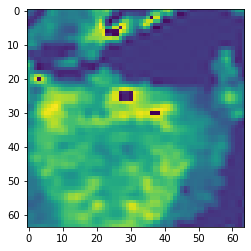

In [24]:
a = next(iter(dl))
i = np.asarray(a[0][0,1])
# i = np.moveaxis(np.asarray(a[0][0]), 0, -1)
# i = np.moveaxis(np.asarray(a[0][0,1:]), 0, -1)
plt.imshow(i)